In [1]:
import pandas as pd
import numpy as np  
import re
from nltk.corpus import stopwords
from numpy import array 


from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Dense
from sklearn.model_selection import train_test_split

2024-08-14 16:38:09.966946: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 16:38:09.971611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 16:38:09.987549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 16:38:10.013636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 16:38:10.021363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 16:38:10.040172: I tensorflow/core/platform/cpu_feature_gu

In [2]:
news = pd.read_csv("news_sentiment_analysis.csv")
news.shape

(3500, 8)

In [3]:
news.head(5)

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business


<Axes: xlabel='Sentiment', ylabel='count'>

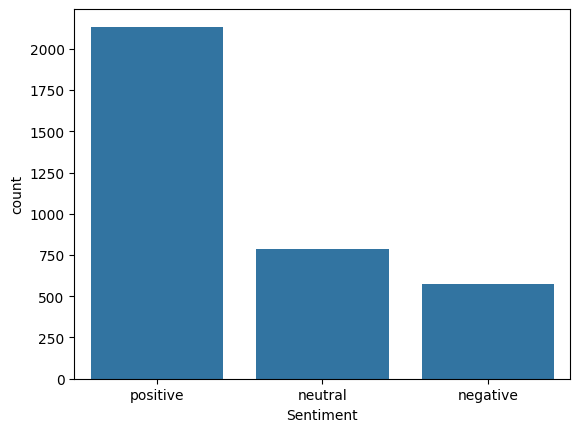

In [4]:
import seaborn as sns
sns.countplot(x='Sentiment', data=news)

In [5]:
news["Description"][0]

'ST. GEORGE — Kaitlyn Larson, a first-year teacher at Pine View High School, recently received the Best in State award for a business leadership course. Larson’s students in grades 10-12 had the highest passing rate on the YouScience exam during the spring and fall semesters of 2023. The YouScience exam is similar to final exams [&#8230;]'

In [6]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/zaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [9]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(news["Description"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [10]:
X[0]

'st george kaitlyn larson first year teacher pine view high school recently received best state award business leadership course larson students grades highest passing rate youscience exam spring fall semesters youscience exam similar final exams '

In [11]:
# Converting sentiment labels to 0 to netutral, -1 negative, 1 positive

y = news['Sentiment']

y = np.array(list(map(lambda x: -1 if x== "negative" else 1 if x == "positive" else 0, y)))

print(y[0], y[1], y[3])

1 0 -1


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, train_size=0.8, random_state=23)

In [13]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [14]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

16782

In [15]:

X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

In [16]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
embedding_matrix.shape

(16782, 100)

## CNN

In [19]:
from keras.layers import Conv1D

In [36]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [37]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,678,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,678,200 (6.40 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,678,200 (6.40 MB)

None


In [76]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.6955 - loss: -268.6237 - val_acc: 0.4429 - val_loss: -259.3761
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - acc: 0.6335 - loss: -255.8286 - val_acc: 0.5482 - val_loss: -264.9906
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.6275 - loss: -309.5903 - val_acc: 0.5089 - val_loss: -269.1483
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.6432 - loss: -268.2195 - val_acc: 0.5304 - val_loss: -273.7205
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - acc: 0.6743 - loss: -297.2353 - val_acc: 0.4929 - val_loss: -278.3495
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.6304 - loss: -341.1181 - val_acc: 0.5429 - val_loss: -284.0663
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.6568 - loss: -351.9483 - val_acc: 0.4982 - val_loss: -288.2296
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.6592 - loss: -362.7879 - val_acc: 0.5089 - val_loss: -293.0581
Epoch 9/10
18/18

In [77]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.5156 - loss: -181.5520


In [78]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -134.26705932617188
Test Accuracy: 0.5471428632736206


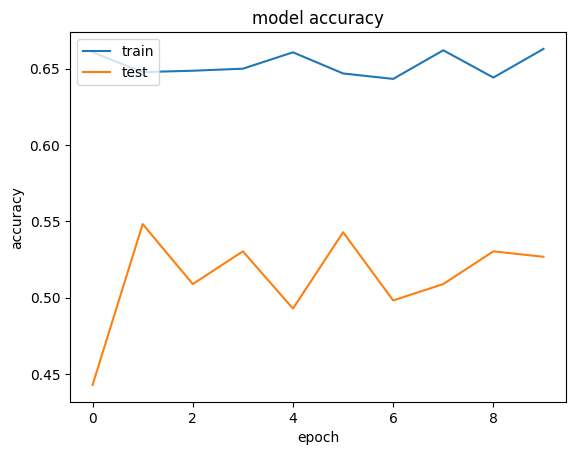

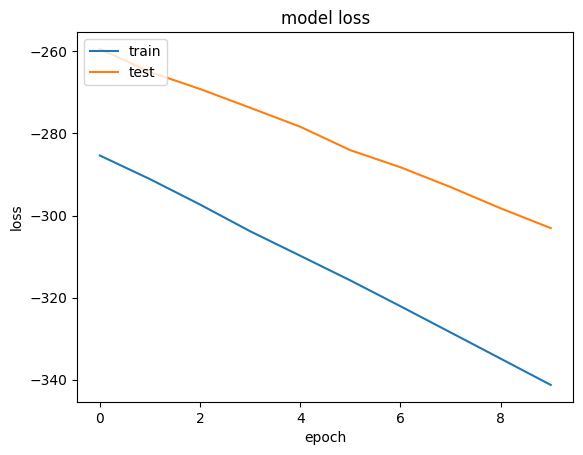

In [79]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()